In [1]:
# ==============================
# 📘 Malawi Stock Exchange Analysis
# ==============================

# Install missing plotting libraries (use magic so it runs in the notebook environment)
%pip install matplotlib seaborn --quiet

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Load Data ---
conn = sqlite3.connect("mse_data.db")
df = pd.read_sql("SELECT * FROM daily_prices", conn)
conn.close()

print("✅ Data loaded successfully!")
print(df.head())


Note: you may need to restart the kernel to use updated packages.
✅ Data loaded successfully!
   Symbol Open Price Close Price % Change  Volume Turnover (MK) scrape_date
0  AIRTEL     130.00      129.97        0   17486    2272741.00  2025-05-16
1     BHL      15.04       15.04        0  151584    2279823.00  2025-05-16
2    FDHB     637.58      637.55        0  222098  141598900.00  2025-05-16
3   FMBCH    2887.66     2887.66        0   35632  102893200.00  2025-05-16
4    ICON      17.95       17.95        0   63538    1140507.00  2025-05-16


In [4]:
print(df.columns)

Index(['Symbol', 'Open Price', 'Close Price', '% Change', 'Volume',
       'Turnover (MK)', 'scrape_date'],
      dtype='object')


In [6]:
# --- 2️⃣ Clean Data ---

df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df = df.sort_values(['Symbol', 'scrape_date'])

# Convert numeric fields
df['Close Price'] = pd.to_numeric(df['Close Price'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Drop missing price rows
df.dropna(subset=['Close Price'], inplace=True)

print("✅ Data cleaned and formatted.")
df.info()


✅ Data cleaned and formatted.
<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 83
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Symbol         80 non-null     object        
 1   Open Price     80 non-null     object        
 2   Close Price    80 non-null     float64       
 3   % Change       80 non-null     object        
 4   Volume         80 non-null     float64       
 5   Turnover (MK)  80 non-null     object        
 6   scrape_date    80 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 5.0+ KB


In [7]:
# --- 3️⃣ Calculate Key Metrics ---

# Daily % Change
df['Daily_Return_%'] = df.groupby('Symbol')['Close Price'].pct_change() * 100

# 20-day Moving Average
df['MA_20'] = df.groupby('Symbol')['Close Price'].transform(lambda x: x.rolling(20, min_periods=1).mean())

# Rolling 20-day Volatility (std of daily returns)
df['Volatility_20'] = df.groupby('Symbol')['Daily_Return_%'].transform(lambda x: x.rolling(20, min_periods=1).std())

# Cumulative Return
df['Cumulative_Return'] = df.groupby('Symbol')['Close Price'].transform(lambda x: x / x.iloc[0] - 1)

# 7-day Volume Trend
df['Vol_MA_7'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(7, min_periods=1).mean())

print("✅ Metrics calculated successfully!")
df.head()


✅ Metrics calculated successfully!


,Symbol,Open Price,Close Price,% Change,Volume,Turnover (MK),scrape_date,Daily_Return_%,MA_20,Volatility_20,Cumulative_Return,Vol_MA_7
0,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-05-16,NaN,129.97,NaN,0.0,17486.0
17,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-05-16,0.0,129.97,NaN,0.0,17486.0
34,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-05-16,0.0,129.97,0.0,0.0,17486.0
51,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-11-08,0.0,129.97,0.0,0.0,17486.0
68,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-11-09,0.0,129.97,0.0,0.0,17486.0


In [8]:
# --- 4️⃣ Save Output to Excel ---
df.to_excel("mse_analysis_output.xlsx", index=False)
print("💾 Results saved to 'mse_analysis_output.xlsx'")


💾 Results saved to 'mse_analysis_output.xlsx'


In [10]:
# --- 5️⃣ Visualization: Setup ---
sns.set(style="whitegrid", palette="tab10")

example_ticker = df['Symbol'].unique()[0]
ticker_df = df[df['Symbol'] == example_ticker]

print(f"📊 Example Ticker: {example_ticker}")


📊 Example Ticker: AIRTEL


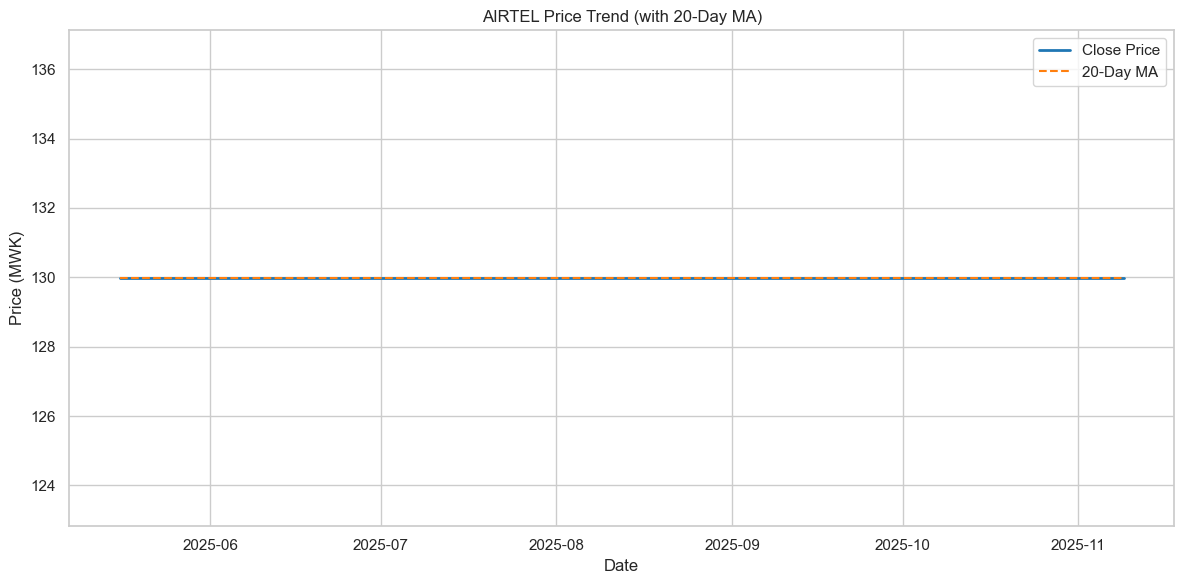

In [12]:
# --- 6️⃣ Plot: Closing Price & Moving Average ---
plt.figure(figsize=(12,6))
plt.plot(ticker_df['scrape_date'], ticker_df['Close Price'], label="Close Price", linewidth=2)
plt.plot(ticker_df['scrape_date'], ticker_df['MA_20'], label="20-Day MA", linestyle="--")
plt.title(f"{example_ticker} Price Trend (with 20-Day MA)")
plt.xlabel("Date")
plt.ylabel("Price (MWK)")
plt.legend()
plt.tight_layout()
plt.show()


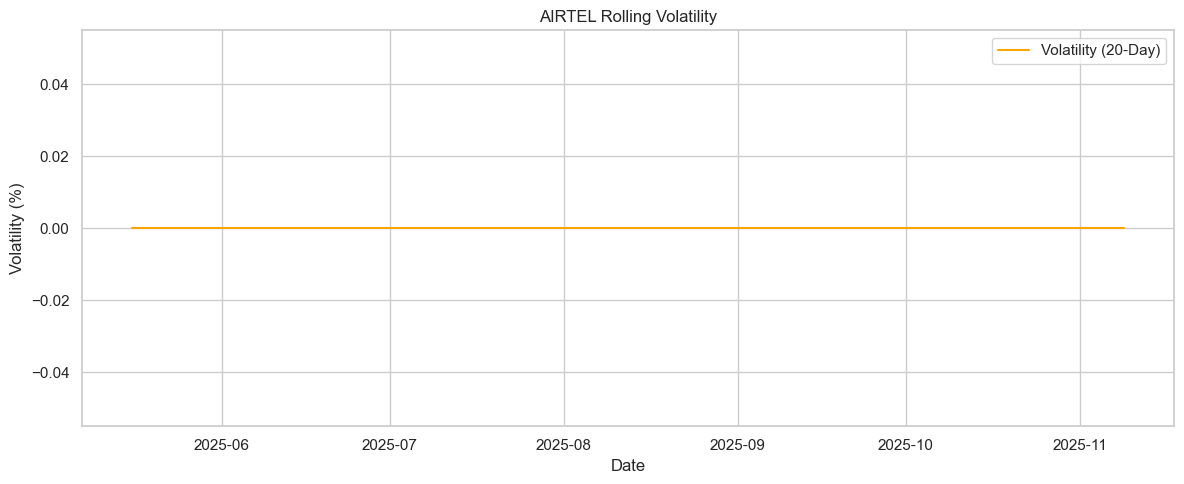

In [13]:
# --- 7️⃣ Plot: Volatility (20-Day Rolling) ---
plt.figure(figsize=(12,5))
plt.plot(ticker_df['scrape_date'], ticker_df['Volatility_20'], color="orange", label="Volatility (20-Day)")
plt.title(f"{example_ticker} Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()


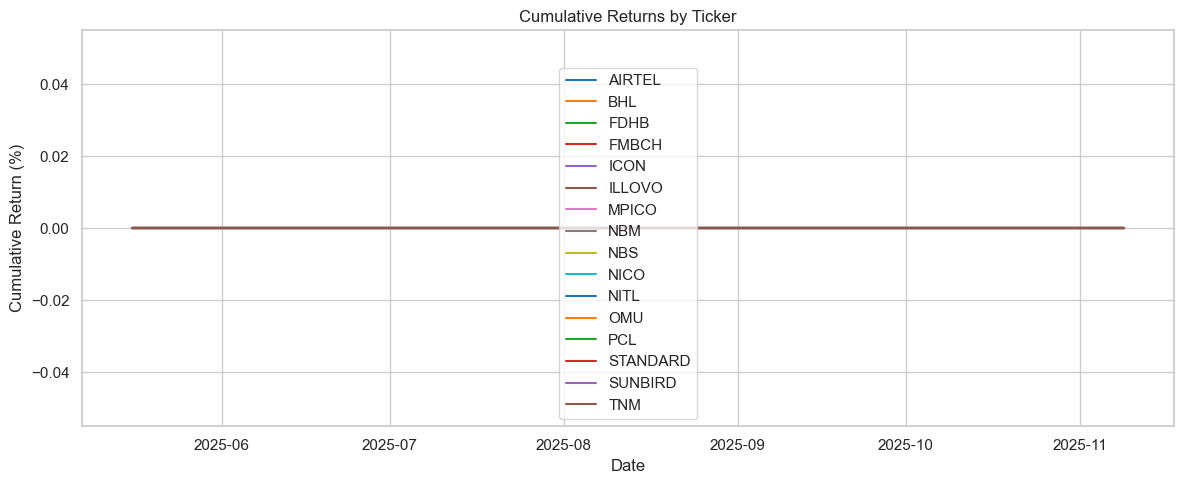

In [14]:
# --- 8️⃣ Plot: Cumulative Returns (All Tickers) ---
plt.figure(figsize=(12,5))
for ticker in df['Symbol'].unique():
    temp = df[df['Symbol'] == ticker]
    plt.plot(temp['scrape_date'], temp['Cumulative_Return'], label=ticker)

plt.title("Cumulative Returns by Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# --- 9️⃣ Summary Performance Table ---
summary = df.groupby('Symbol').agg({
    'Daily_Return_%': 'mean',
    'Volatility_20': 'mean',
    'Cumulative_Return': 'last',
    'Volume': 'mean'
}).rename(columns={
    'Daily_Return_%': 'Avg Daily Return (%)',
    'Volatility_20': 'Avg Volatility (%)',
    'Cumulative_Return': 'Total Return',
    'Volume': 'Avg Volume'
}).reset_index()

print("📋 === Summary Performance ===")
display(summary.round(2))


📋 === Summary Performance ===


,Symbol,Avg Daily Return (%),Avg Volatility (%),Total Return,Avg Volume
0,AIRTEL,0.0,0.0,0.0,17486.0
1,BHL,0.0,0.0,0.0,151584.0
2,FDHB,0.0,0.0,0.0,222098.0
3,FMBCH,0.0,0.0,0.0,35632.0
4,ICON,0.0,0.0,0.0,63538.0
5,ILLOVO,0.0,0.0,0.0,8300.0
6,MPICO,0.0,0.0,0.0,43803.0
7,NBM,0.0,0.0,0.0,1006.0
8,NBS,0.0,0.0,0.0,141614.0
9,NICO,0.0,0.0,0.0,15932.0
